In [ ]:
import pickle
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip '/content/gdrive/MyDrive/Spectrum_Generator/raw_tables_2023_03_06.zip'

In [80]:
with open("raw_user_profiles", "rb") as raw_timeline_file:
    user_df = pd.read_pickle(raw_timeline_file)

with open("raw_tweets", "rb") as raw_timeline_file:
    tweet_df = pd.read_pickle(raw_timeline_file)

pd.set_option('display.max_colwidth', None)

In [81]:
house_df = pd.read_csv('congress_twitter_117th_house.csv', sep=',', header=0)
senate_df = pd.read_csv('congress_twitter_117th_senate.csv', sep=',', header=0)

In [82]:
house_df['user_name'] = house_df['Link'].apply(lambda x: x.rsplit('/', 1)[-1])
senate_df['user_name'] = senate_df['Link'].apply(lambda x: x.rsplit('/', 1)[-1])

In [83]:
senate_df.columns = house_df.columns
party_lookup = pd.concat([house_df, senate_df], axis=0)

In [84]:
tweet_df = tweet_df.merge(party_lookup, on="user_name")
tweet_df['hashtag_len'] = tweet_df['hashtags'].apply(len)
with_tags = tweet_df[tweet_df['hashtag_len'] > 0]
with_tags = with_tags.explode('hashtags')

In [85]:
# on average, Democratic congressmen use more hashtags than Replublic congressmen
print(f"ratio of hashtags used per tweets for Democratic congressmen is { len(with_tags[with_tags['Party'] == 'D']) / len(tweet_df[tweet_df['Party']=='D']):.2}")
print(f"ratio of hashtags used per tweets for Republican congressmen is { len(with_tags[with_tags['Party'] == 'R']) / len(tweet_df[tweet_df['Party']=='R']):.2}")

ratio of hashtags used per tweets for Democratic congressmen is 0.6
ratio of hashtags used per tweets for Republican congressmen is 0.49


In [86]:
frequency_D = with_tags[with_tags['Party'] == 'D'].groupby('hashtags', as_index=False)['id'].count().sort_values(by=['id'], ascending=False)
frequency_R = with_tags[with_tags['Party'] == 'R'].groupby('hashtags', as_index=False)['id'].count().sort_values(by=['id'], ascending=False)

In [87]:
# Top 10 hashtags used by Democratic congressmen
frequency_D.iloc[:10]

,hashtags,id
10504,COVID19,23186
1793,ACA,9700
23239,ForThePeople,9376
4122,AmericanRescuePlan,8117
9063,BuildBackBetter,7893
56736,SOTU,7669
56160,SCOTUS,5842
25232,GetCovered,5421
51909,ProtectOurCare,5329
24643,GOPTaxScam,5274


In [88]:
# Top 10 hashtags used by Republican congressmen
frequency_R.iloc[:10]

,hashtags,id
55555,tcot,8621
6661,COVID19,7668
29047,Obamacare,6841
34847,SOTU,5977
50522,jobs,4207
29198,Ohio,3961
56384,utpol,3733
4714,BidenBorderCrisis,3177
39080,TaxReform,3055
737,4jobs,3053


In [89]:
# get the overall top 100 hashtags used and their log values for visualization
top_overall = with_tags.groupby(('hashtags'), as_index = False)['id'].count().sort_values(by=['id'], ascending=False).iloc[:100]
top_overall = top_overall.merge(frequency_D, on='hashtags', how='left')
top_overall = top_overall.merge(frequency_R, on='hashtags', how='left')
top_overall

,hashtags,id_x,id_y,id
0,COVID19,30854,23186.0,7668.0
1,SOTU,13789,7669.0,5977.0
2,ACA,10223,9700.0,396.0
3,ForThePeople,9493,9376.0,116.0
4,tcot,8698,72.0,8621.0
...,...,...,...,...
95,Venezuela,1854,154.0,1699.0
96,mtpol,1852,1757.0,95.0
97,Missouri,1825,13.0,1811.0
98,budget,1815,831.0,620.0


In [90]:
top_overall['log_freq_D'] = np.log(top_overall['id_y'])
top_overall['log_freq_R'] = np.log(top_overall['id'])
top_overall['log_freq_overall'] = np.log(top_overall['id_x'])

Text(0, 0.5, 'log hashtag use frequency by Republican congressmen')

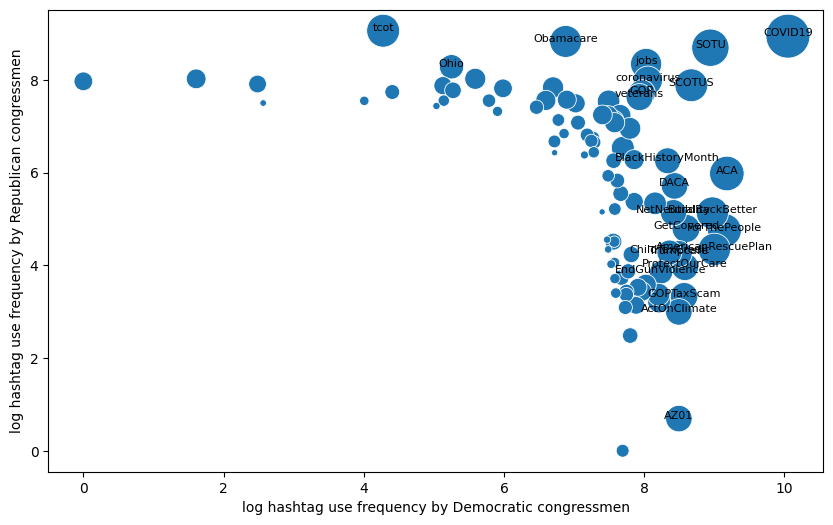

In [91]:
# visualize the top 100 hashtags used
import seaborn as sns
import matplotlib.pyplot as plt

to_label = top_overall.iloc[:25]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_overall, x="log_freq_D", y="log_freq_R", size="log_freq_overall",\
                sizes=(20, 1000), legend = False)
for x, y, label in zip(to_label["log_freq_D"], to_label["log_freq_R"], to_label["hashtags"]):
    plt.text(x, y, label, fontsize=8, ha="center")

plt.xlabel("log hashtag use frequency by Democratic congressmen")
plt.ylabel("log hashtag use frequency by Republican congressmen")